In [1]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
import keras
keras.__version__

Using TensorFlow backend.


'2.2.2'

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [4]:
# # Create smaller dataset for Dogs vs. Cats
# import os, shutil

# original_dataset_dir = '/home/deeplearn/deepfun/keras/train/'

# base_dir = '/home/deeplearn/deepfun/keras/data'
# if not os.path.exists(base_dir):
#     os.mkdir(base_dir)

# # Create directories
# train_dir = os.path.join(base_dir,'train')
# if not os.path.exists(train_dir):
#     os.mkdir(train_dir)
# validation_dir = os.path.join(base_dir,'validation')
# if not os.path.exists(validation_dir):
#     os.mkdir(validation_dir)
# test_dir = os.path.join(base_dir,'test')
# if not os.path.exists(test_dir):
#     os.mkdir(test_dir)

# train_cats_dir = os.path.join(train_dir,'cats')
# if not os.path.exists(train_cats_dir):
#     os.mkdir(train_cats_dir)

# train_dogs_dir = os.path.join(train_dir,'dogs')
# if not os.path.exists(train_dogs_dir):
#     os.mkdir(train_dogs_dir)

# validation_cats_dir = os.path.join(validation_dir,'cats')
# if not os.path.exists(validation_cats_dir):
#     os.mkdir(validation_cats_dir)

# validation_dogs_dir = os.path.join(validation_dir, 'dogs')
# if not os.path.exists(validation_dogs_dir):
#     os.mkdir(validation_dogs_dir)

# test_cats_dir = os.path.join(test_dir, 'cats')     
# if not os.path.exists(test_cats_dir):
#     os.mkdir(test_cats_dir)

# test_dogs_dir = os.path.join(test_dir, 'dogs')
# if not os.path.exists(test_dogs_dir):
#     os.mkdir(test_dogs_dir)

# # Copy first 1000 cat images to train_cats_dir
# fnames = ['cat.{}.jpg'.format(i) for i in range(0, 1000)]
# for fname in fnames:
#     src = os.path.join(original_dataset_dir, fname)
#     dst = os.path.join(train_cats_dir, fname)
#     shutil.copyfile(src, dst)
    
# # Copy next 500 cat images to validation_cats_dir
# fnames = ['cat.{}.jpg'.format(i) for i in range(1001, 1501)]
# for fname in fnames:
#     src = os.path.join(original_dataset_dir, fname)
#     dst = os.path.join(validation_cats_dir, fname)
#     shutil.copyfile(src, dst)
    
# # Copy next 500 cat images to test_cats_dir
# fnames = ['cat.{}.jpg'.format(i) for i in range(1502,2002)]
# for fname in fnames:
#     src = os.path.join(original_dataset_dir, fname)
#     dst = os.path.join(test_cats_dir, fname)
#     shutil.copyfile(src, dst)
    
# # Copy first 1000 dog images to train_dogs_dir
# fnames = ['dog.{}.jpg'.format(i) for i in range(0,1000)]
# for fname in fnames:
#     src = os.path.join(original_dataset_dir, fname)
#     dst = os.path.join(train_dogs_dir, fname)
#     shutil.copyfile(src, dst)
                                                
# # Copy next 500 dog images to validation_dogs_dir
# fnames = ['dog.{}.jpg'.format(i) for i in range(1001,1501)]
# for fname in fnames:
#     src = os.path.join(original_dataset_dir, fname)
#     dst = os.path.join(validation_dogs_dir, fname)
#     shutil.copyfile(src, dst)

# # Copy next 500 dog images to test_dogs_dir
# fnames = ['dog.{}.jpg'.format(i) for i in range(1502,2002)]
# for fname in fnames:
#     src = os.path.join(original_dataset_dir, fname)
#     dst = os.path.join(test_dogs_dir, fname)
#     shutil.copyfile(src, dst)
                                                
# # Sanity checks
# print('total training cat images:', len(os.listdir(train_cats_dir)))
# print('total training dog images:', len(os.listdir(train_dogs_dir)))
# print('total validation cat images:', len(os.listdir(validation_cats_dir)))
# print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
# print('total test cat images:', len(os.listdir(test_cats_dir)))
# # print('total test dog images:', len(os.listdir(test_dogs_dir)))

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir =  '/home/ec2-user/SageMaker/data/transferLearning'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [7]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 514us/step - loss: 0.6120 - acc: 0.6670 - val_loss: 0.4430 - val_acc: 0.8510
Epoch 2/30
2000/2000 [==============================] - 1s 284us/step - loss: 0.4266 - acc: 0.8095 - val_loss: 0.3612 - val_acc: 0.8730
Epoch 3/30
2000/2000 [==============================] - 1s 281us/step - loss: 0.3636 - acc: 0.8465 - val_loss: 0.3257 - val_acc: 0.8750
Epoch 4/30
2000/2000 [==============================] - 1s 283us/step - loss: 0.3194 - acc: 0.8680 - val_loss: 0.3036 - val_acc: 0.8820
Epoch 5/30
2000/2000 [==============================] - 1s 282us/step - loss: 0.2981 - acc: 0.8765 - val_loss: 0.2862 - val_acc: 0.8960
Epoch 6/30
2000/2000 [==============================] - 1s 285us/step - loss: 0.2736 - acc: 0.8955 - val_loss: 0.2731 - val_acc: 0.8980
Epoch 7/30
2000/2000 [==============================] - 1s 283us/step - loss: 0.2542 - acc: 0.8985 - val_loss: 0.2665 - val_acc: 0.8940


In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [9]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [11]:
# lets Freeze the pre-trained conv layer
print('These are the # of trainable weights before freezing the conv base: ', len(model.trainable_weights))

These are the # of trainable weights before freezing the conv base:  30


In [12]:
conv_base.trainable = False

In [13]:
print('These are the # of trainable weights before freezing the conv base: ', len(model.trainable_weights))

These are the # of trainable weights before freezing the conv base:  4


In [14]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
train_generator,
steps_per_epoch = 100,
epochs = 30,
validation_data = validation_generator,
validation_steps = 50,
verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 22s - loss: 0.5970 - acc: 0.6870 - val_loss: 0.4495 - val_acc: 0.8310
Epoch 2/30
 - 20s - loss: 0.4781 - acc: 0.7895 - val_loss: 0.3615 - val_acc: 0.8660
Epoch 3/30
 - 20s - loss: 0.4322 - acc: 0.8125 - val_loss: 0.3484 - val_acc: 0.8540
Epoch 4/30
 - 20s - loss: 0.4036 - acc: 0.8235 - val_loss: 0.3109 - val_acc: 0.8730
Epoch 5/30
 - 20s - loss: 0.3798 - acc: 0.8440 - val_loss: 0.2932 - val_acc: 0.8830
Epoch 6/30
 - 20s - loss: 0.3735 - acc: 0.8360 - val_loss: 0.2849 - val_acc: 0.8890
Epoch 7/30
 - 20s - loss: 0.3659 - acc: 0.8385 - val_loss: 0.2756 - val_acc: 0.8940
Epoch 8/30
 - 20s - loss: 0.3534 - acc: 0.8405 - val_loss: 0.2669 - val_acc: 0.9000
Epoch 9/30
 - 20s - loss: 0.3367 - acc: 0.8540 - val_loss: 0.2608 - val_acc: 0.8970
Epoch 10/30
 - 20s - loss: 0.3341 - acc: 0.8595 - val_loss: 0.2607 - val_acc: 0.8970
Epoch 11/30
 - 20s - loss: 0.3296 - acc: 0.8595 - val_loss: 0.2558 - val_ac

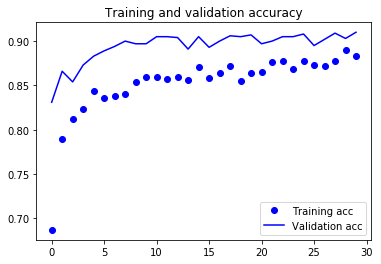

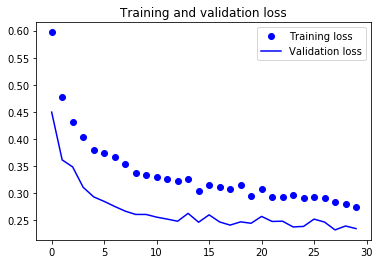

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [22]:
model.compile(loss='binary_crossentropy',
             optimizer = optimizers.RMSprop(lr=2e-5),
             metrics = ['acc'])
history = model.fit_generator(
train_generator,
steps_per_epoch = 100,
epochs = 100,
validation_data = validation_generator,
validation_steps = 50)

Epoch 1/100
100/100 [==============================] - 24s 238ms/step - loss: 0.2903 - acc: 0.8780 - val_loss: 0.2008 - val_acc: 0.9280
Epoch 2/100
100/100 [==============================] - 22s 224ms/step - loss: 0.2263 - acc: 0.9120 - val_loss: 0.2036 - val_acc: 0.9260
Epoch 3/100
100/100 [==============================] - 23s 227ms/step - loss: 0.2104 - acc: 0.9150 - val_loss: 0.1786 - val_acc: 0.9360
Epoch 4/100
100/100 [==============================] - 23s 229ms/step - loss: 0.1951 - acc: 0.9165 - val_loss: 0.2027 - val_acc: 0.9160
Epoch 5/100
100/100 [==============================] - 23s 228ms/step - loss: 0.1808 - acc: 0.9295 - val_loss: 0.1911 - val_acc: 0.9360
Epoch 6/100
100/100 [==============================] - 23s 228ms/step - loss: 0.1669 - acc: 0.9345 - val_loss: 0.1781 - val_acc: 0.9310
Epoch 7/100
100/100 [==============================] - 23s 228ms/step - loss: 0.1576 - acc: 0.9380 - val_loss: 0.1965 - val_acc: 0.9200
Epoch 8/100
100/100 [===========================

In [23]:
model.save('cats_dogs_mymodel_finetuned_1.h5')

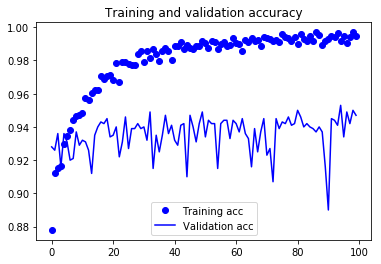

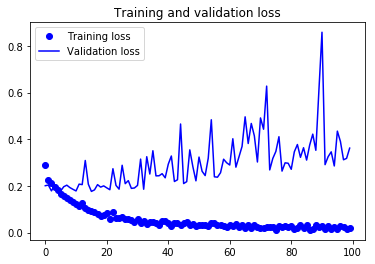

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()